In [1]:
import grammars1 as gm
import matplotlib.pyplot as plt

Define grammar for test and it's transition/emission probabilities:

In [2]:
grammar31 = [('E', 'AE'), ('E', 'BE'), ('E', 'e'),
             ('A', 'AE'), ('A', 'a'), ('A', 'e'),
             ('B', 'BE'), ('B', 'AE'), ('B', 'b')]

ts31 = {
    ('E', 'AE'): 1/4, ('E', 'BE'): 1/4, ('E', 'e'): 1/2,
    ('A', 'AE'): 8/27, ('A', 'a'): 2/3, ('A', 'e'): 1/27,
    ('B', 'BE'): 26/81, ('B', 'AE'): 1/81, ('B', 'b'): 2/3
}


Inside algorithm (see. Durbin p. 254):<br><br>

init:<br>
$\alpha(:, i, i)=e_{v}(x_{i})$<br>
main:<br>
$\alpha(v, i, j)=\sum_{y=1}^{M}\sum_{z=1}^{M}\sum_{k=i}^{j-1}\alpha(y, i, k)\alpha(z, k+1, j)t_{v}(y,z)$<br>
termination:<br>
$P(x|\theta)=\alpha(1,L,1)$


In [3]:
ires = gm.inside(sent=list('aae'), grammar=grammar31,
                 ts=ts31, debug=False)
p, alpha = ires

In [4]:
print("alpha:")
print(alpha)

alpha:
[[[0.         0.         0.01388889]
  [0.         0.         0.08333333]
  [0.         0.         0.5       ]]

 [[0.66666667 0.         0.01646091]
  [0.         0.66666667 0.09876543]
  [0.         0.         0.03703704]]

 [[0.         0.         0.00068587]
  [0.         0.         0.00411523]
  [0.         0.         0.        ]]]


In [5]:
print("p(sent|grammar) = alpha(1, L, 1):")
print(p)

p(sent|grammar) = alpha(1, L, 1):
0.013888888888888888


Outside algorithm (see. Durbin p. 255):<br><br>
init:<br>
$\beta("E", 1, L)=1$<br>
$\beta(:, 1, L)=0$<br>
main:<br>
$\beta(v, i, j)=\sum_{y,z}\sum_{k=1}^{i-1}\alpha(z, k, i-1)\beta(y, k, j)t_{y}(z,v)
     +\sum_{y,z}\sum_{k=j+1}^{L}\alpha(z, j+1, k)\beta(y, i, k)t_{y}(v,z)$<br>
termination:<br>
$P(x|\theta)=\sum_{v=1}^{M}\beta(v,i,i)e_{v}(x_{i})$

In [6]:
ores = gm.outside(alpha, sent=list("aae"), grammar=grammar31,
                  ts=ts31, debug=False)
pb, beta = ores

In [7]:
print("beta:")
print(beta)

beta:
[[[0.         0.         1.        ]
  [0.         0.02572016 0.16666667]
  [0.         0.         0.02777778]]

 [[0.02083333 0.125      0.        ]
  [0.         0.02083333 0.        ]
  [0.         0.         0.        ]]

 [[0.02083333 0.125      0.        ]
  [0.         0.02083333 0.        ]
  [0.         0.         0.        ]]]


In [8]:
print("p(sent|grammar) = \sum_{v \in [1 .. M]} beta(i, i, v) * e_{v}(x_{i}):")
print(pb)

p(sent|grammar) = \sum_{v \in [1 .. M]} beta(i, i, v) * e_{v}(x_{i}):
[0.013888888888888888, 0.013888888888888888, 0.013888888888888888]


EM algorithm (see. Durbin p. 255):<br><br>
$t_{v}(y, z) = \frac{c(v->yz)}{c(v)}$<br>
$e_{v}(a) = \frac{c(v->a)}{c(v)}$


In [9]:
t, e, c, c_unterm, c_term = gm.em_step(alpha, beta, sent=list('aae'),
                                    grammar=grammar31, ts=ts31,
                                    debug=False)


In [10]:
print("estimated transitions:")
for rule in t:
    print(rule, ": ", t[rule])


estimated transitions:
('E', 'AE') :  0.6666666666666666
('E', 'BE') :  0.0
('A', 'AE') :  0.0
('B', 'BE') :  0
('B', 'AE') :  0


In [11]:
print("estimated emission:")
for rule in e:
    print(rule, ": ", e[rule])


estimated emission:
('E', 'e') :  0.3333333333333333
('A', 'a') :  1.0
('A', 'e') :  0.0
('B', 'b') :  0


All rules like $W_{v}->W_{y}W_{z}$ and $W_{v}-> a$ sum to 1 for same $W_{v}$:

In [12]:
for w in ["E", "A", "B"]:
    print(sum([t[(v, yz)] for (v, yz) in t if v == w]
               + [e[(v, x)] for (v, x) in e if v == w]))

1.0
1.0
0


#### EM alg:
generate sentences, and lern SCFG grammar parameters for them

1) generate sentences:

In [13]:
grammar = grammar31
ts_orign = ts31
N = 20
max_sent_len = 100
# actualy not used
sent_len = 4

lsents = []
idx_max_len = 0
max_len = 0

while len(lsents) < N:
        lsent = gm.backward.gen_sent(grammar, sent_len, probs=ts_orign)

        # exclude triviality:
        len_lsent = len(lsent)
        if (len_lsent > 1 and 'a' in lsent and 'b' in lsent
            and len_lsent < max_sent_len):
            lsents.append(lsent)
            
            # max len sent in front:
            if len_lsent > max_len:
                idx_max_len = len(lsents)-1
                max_len = len_lsent

# max len sent in front:
# for all rules initiated at first
# with no zero probabilities:
max_sent = lsents.pop(idx_max_len)
lsents.insert(0, max_sent)
for lsent in lsents[:7]:
    print("".join(lsent))

bbebebbbeebabababbeebaeaeaeebbeeaeaeebeebabe
abe
abaeabeae
beebeaeeabeebaeaebee
baebeeeae
aebabe
abe


2) given sentences and random init SCFG, lern parameters:

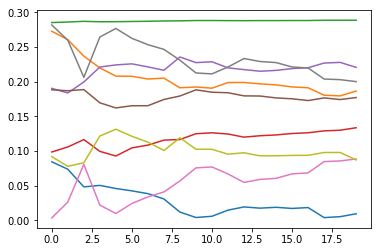


original ts:
('E', 'AE') :  0.25
('E', 'BE') :  0.25
('E', 'e') :  0.5
('A', 'AE') :  0.2962962962962963
('A', 'a') :  0.6666666666666666
('A', 'e') :  0.037037037037037035
('B', 'BE') :  0.32098765432098764
('B', 'AE') :  0.012345679012345678
('B', 'b') :  0.6666666666666666
lerned ts:
('E', 'AE') :  0.24057302161788266
('E', 'BE') :  0.436404612714747
('E', 'e') :  0.3230223656673704
('A', 'AE') :  0.007841228385544505
('A', 'a') :  0.7551332233328191
('A', 'e') :  0.2370255482816363
('B', 'BE') :  0.18750040706920365
('B', 'AE') :  0.23288155245010772
('B', 'b') :  0.5796180404806887


In [14]:
ts, xs = gm.em(sents=lsents, grammar=grammar,
               ts_orign=ts_orign, debug=False)

plt.plot(xs.T)
plt.show()

print("\noriginal ts:")
for rule in ts_orign:
    print(rule, ": ", ts_orign[rule])
print("lerned ts:")
for rule in ts_orign:
    if rule in ts:
        print(rule, ": ", ts[rule])
    else:
        pass
        # print(rule, ": ", es[rule])


#### Important note:
Depend on init grammar lerned SCFG will be different <br>
So there is strong dependece on init parameters